## Import libraries and read data

In [29]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.layers import Input, Dense
from keras.models import Model
from keras.backend import tf

DATA_PATH = '../data/final/final_dataset_30T.csv'

In [30]:
data = pd.read_csv(DATA_PATH, sep='\t', index_col=[0])
data.head()

,"('avg_Length', 'avg_2019-02-01 09:30:00')","('avg_Length', 'avg_2019-02-01 10:00:00')","('avg_Length', 'avg_2019-02-01 10:30:00')","('avg_Length', 'avg_2019-02-01 11:00:00')","('avg_Length', 'avg_2019-02-01 11:30:00')","('avg_Length', 'avg_2019-02-01 12:00:00')","('avg_Length', 'avg_2019-02-01 12:30:00')","('avg_Length', 'avg_2019-02-01 13:00:00')","('avg_Length', 'avg_2019-02-01 13:30:00')","('avg_Length', 'avg_2019-02-01 14:00:00')",...,"('count_Port2_last_1', 'count_2019-02-01 22:00:00')",host0,host1,host2,host3,host4,host5,host6,host7,is_src
1.0.171.245source,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1,1,1,1,0,1,0,1,1
1.0.255.54source,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.219512,0.0,...,0.0,0,0,1,1,0,1,1,0,1
1.1.158.248source,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1,1,1,1,1,0,0,0,1
1.1.217.60source,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0,0,1,1,1,1,0,0,1
1.1.230.15source,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,1,1,1,1,1


## Scale input

In [31]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## Isolation Forest

In [75]:
i_forest = IsolationForest(n_estimators=500,
                           random_state=101,
                           verbose=1,
                           n_jobs=-1,
                           contamination=0.01,
                           behaviour='new')
results = i_forest.fit_predict(data_scaled)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   54.8s remaining:  3.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   55.1s finished


Things tried:

* 1000 estimators - not much difference
* contamination "legacy" - always found about a 10% anomalies
* contamination "auto" - worked better than legacy bringing down to 5%
* behaviour "old" - 10% anomalies
* contamination can be tackled as a threshold


## Apply PCA in order to plot the results

In [76]:
pca = PCA(n_components=3, ).fit(data)
print(pca.explained_variance_ratio_.sum())
data_pca = pca.transform(data)
print(np.unique(results, return_counts=True))

0.9512598719959943


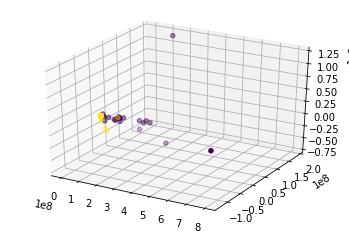

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data_pca[:,0], data_pca[:,1], data_pca[:,2], c=results, )

## Autoencoder

In [81]:
latent_dim = ceil(data.shape[1]/25)
dim_2 = ceil(data.shape[1]/10)
dim_1 = ceil(data.shape[1]/5)
print(latent_dim)

45


In [82]:
input_ = Input(shape=(data.shape[1],))
encoded = Dense(dim_1, activation='tanh')(input_)
encoded = Dense(dim_2, activation='tanh')(encoded)
encoded = Dense(latent_dim, activation='tanh')(encoded)

decoded = Dense(dim_2, activation='tanh')(encoded)
decoded = Dense(dim_1, activation='tanh')(decoded)
decoded = Dense(data.shape[1], activation='sigmoid')(decoded)

Things tried:
* activation relu - better tanh due to standar scaling
* optimizer adadelta - worse performance than adam
* optimizer sgd - worse performance than adam

In [93]:
autoencoder = Model(input_, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

anomaly = autoencoder.fit(data_scaled, data_scaled,
                epochs=30,
                batch_size=256,
                shuffle=True,)


Epoch 1/30
46713/46713 [==============================] - 9s 183us/step - loss: 0.9064
Epoch 2/30
46713/46713 [==============================] - 8s 182us/step - loss: 0.9064
Epoch 3/30
46713/46713 [==============================] - 9s 183us/step - loss: 0.9063
Epoch 4/30
46713/46713 [==============================] - 8s 179us/step - loss: 0.9062
Epoch 5/30
46713/46713 [==============================] - 9s 184us/step - loss: 0.9062
Epoch 6/30
46713/46713 [==============================] - 9s 187us/step - loss: 0.9060
Epoch 7/30
46713/46713 [==============================] - 9s 193us/step - loss: 0.9058
Epoch 8/30
46713/46713 [==============================] - 9s 183us/step - loss: 0.9058
Epoch 9/30
46713/46713 [==============================] - 9s 191us/step - loss: 0.9057
Epoch 10/30
46713/46713 [==============================] - 8s 180us/step - loss: 0.9057
Epoch 11/30
46713/46713 [==============================] - 9s 185us/step - loss: 0.9057
Epoch 12/30
46713/46713 [================

Things tried:
* epochs above 25/30, seems to overfit

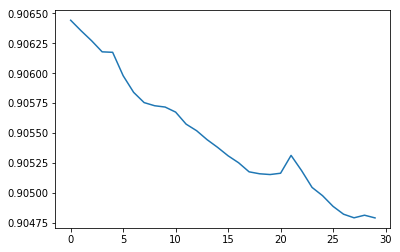

In [94]:
plt.plot(anomaly.history['loss'])

In [95]:
ae_results = autoencoder.predict(data_scaled)
mse = np.mean(np.power(data_scaled - ae_results, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
error_df.describe()

,Reconstruction_error
count,46713.000000
mean,0.904802
std,35.999124
min,0.010060
25%,0.015731
50%,0.017726
75%,0.026458
max,6278.324230


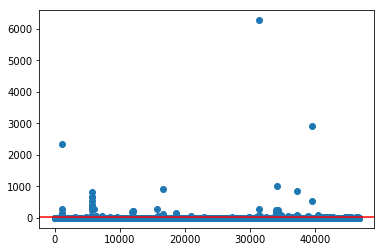

In [96]:
plt.scatter(x=error_df.index, y=error_df)
plt.axhline(y=error_df.values.mean() + error_df.values.std(),color='r' )

In [97]:
threshold = error_df.values.mean() + error_df.values.std()
idx_ae = error_df.values > threshold
anomalies = error_df[error_df.values > threshold]
print(anomalies.shape)
data[idx_ae].head()

(74, 1)


,"('avg_Length', 'avg_2019-02-01 09:30:00')","('avg_Length', 'avg_2019-02-01 10:00:00')","('avg_Length', 'avg_2019-02-01 10:30:00')","('avg_Length', 'avg_2019-02-01 11:00:00')","('avg_Length', 'avg_2019-02-01 11:30:00')","('avg_Length', 'avg_2019-02-01 12:00:00')","('avg_Length', 'avg_2019-02-01 12:30:00')","('avg_Length', 'avg_2019-02-01 13:00:00')","('avg_Length', 'avg_2019-02-01 13:30:00')","('avg_Length', 'avg_2019-02-01 14:00:00')",...,"('count_Port2_last_1', 'count_2019-02-01 22:00:00')",host0,host1,host2,host3,host4,host5,host6,host7,is_src
103.9.177.185source,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,48.000000,...,0.0,1,0,1,1,1,0,0,1,1
104.192.1.15source,60.000000,59.978492,59.802326,60.000000,60.854239,60.613653,60.000000,60.401041,60.548171,59.983181,...,0.0,0,0,0,0,1,1,1,1,1
104.248.135.165source,61.504604,61.425604,61.297026,61.551904,61.367338,61.300701,61.305091,61.803109,61.171340,61.223111,...,0.0,1,0,1,0,0,1,0,1,1
104.248.37.237source,61.878968,61.898538,61.447473,59.957901,60.179832,59.987654,60.796984,60.464435,61.751657,61.767182,...,400.0,1,1,1,0,1,1,0,1,1
115.133.239.238source,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1828.0,1,1,1,0,1,1,1,0,1


Threshold can be an argument for each model

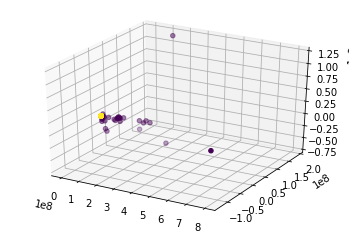

In [74]:
anomalies = np.zeros((len(data),1))
anomalies[idx_ae] = -1
anomalies = anomalies.reshape(len(anomalies), )
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data_pca[:,0], data_pca[:,1], data_pca[:,2], c=anomalies, )

In [53]:
data[idx_ae]['is_src'].value_counts()

0    116
1     73
Name: is_src, dtype: int64

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data_pca[:,0], data_pca[:,1], data_pca[:,2], c=results_pca, )

In [103]:
i_forest.max_samples_

256

In [106]:
autoencoder.history.history['loss']

[0.9064423261840375,
 0.9063538048198104,
 0.9062705341650541,
 0.9061782598760886,
 0.9061743006918203,
 0.905978893285909,
 0.9058395075524784,
 0.9057539843305611,
 0.9057277964206646,
 0.9057167675431068,
 0.9056745985791579,
 0.905573931195599,
 0.905519075244949,
 0.9054440302053424,
 0.9053798605089862,
 0.9053093448424516,
 0.9052512138864082,
 0.9051753603965232,
 0.9051590636587887,
 0.9051527036212991,
 0.9051635901411382,
 0.9053126300631457,
 0.9051858335347431,
 0.9050450101971685,
 0.9049760105343827,
 0.9048867787165523,
 0.904821130046852,
 0.9047910679390371,
 0.904812794386469,
 0.9047901486930923]